<a href="https://colab.research.google.com/github/Bilalhussain0509/Brain-Tumor-Detection-FYP/blob/main/FYP_Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#Imports Libraries and Tools
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [36]:
#Load Datasets
import os
from sklearn.utils import shuffle

# Directories for training and testing data
train_dir = '/content/drive/MyDrive/DataSet_MRI_scans/brain_tumor_dataset'
test_dir = '/content/drive/MyDrive/DataSet_MRI_scans/brain_tumor_dataset'

# Load and shuffle train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label.lower())  # Normalize label case

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label.lower())

test_paths, test_labels = shuffle(test_paths, test_labels)

# Prepare label mapping
class_labels = sorted(list(set(train_labels)))
label_to_index = {label: idx for idx, label in enumerate(class_labels)}
print("Class-to-index mapping:", label_to_index)


Class-to-index mapping: {'no-tumor': 0, 'tumor': 1}


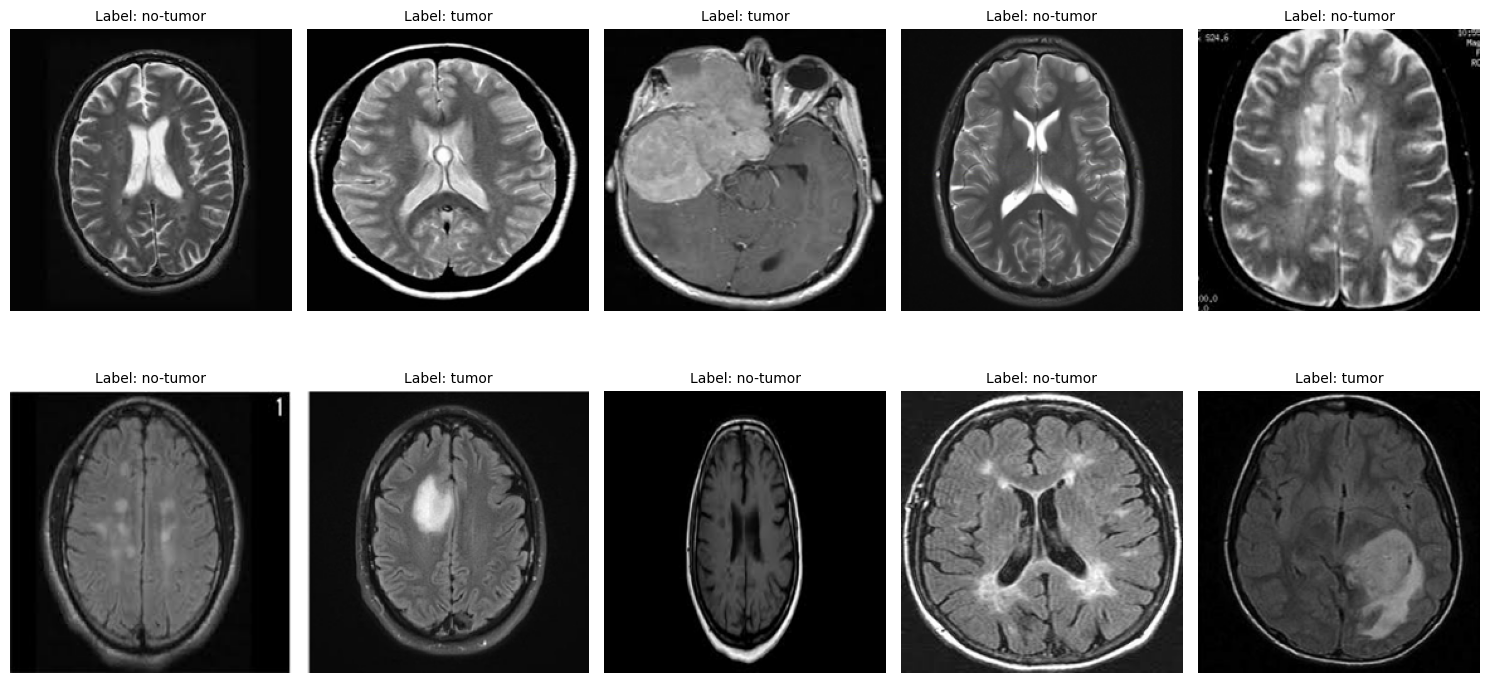

In [37]:
#Data Visualization
import random
import matplotlib.pyplot as plt
from PIL import Image

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    try:
        img = Image.open(img_path).convert('RGB')  # Ensure 3-channel input
        img = img.resize((224, 224))  # Resize for VGG16

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

    except Exception as e:
        print(f"Error loading image: {img_path}\n{str(e)}")
        axes[i].axis('off')
        axes[i].set_title("Error", fontsize=10)

plt.tight_layout()
plt.show()


In [38]:
#Image Preprocessing (Helper Functions)
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import ImageEnhance, Image
import random

IMAGE_SIZE = 224  # Make sure this is defined globally

# Augmentation: Random brightness and contrast + normalization
def augment_image(image_array):
    image = Image.fromarray(np.uint8(image_array))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image)
    return image / 255.0  # Normalize to [0, 1]

# Load and preprocess a batch of images
def open_images(paths, augment=True):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = img_to_array(image)
        if augment:
            image = augment_image(image)
        else:
            image = image / 255.0
        images.append(image)
    return np.array(images)

# Encode labels once (use consistent label_to_index from part 1)
def encode_labels(labels, label_to_index):
    return np.array([label_to_index[label.lower()] for label in labels])

# Data generator for batching
def datagen(paths, labels, label_to_index, batch_size=12, epochs=1, augment=True):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths, augment=augment)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_labels(batch_labels, label_to_index)
            yield batch_images, batch_labels


In [39]:
#MODEL:
#WE ARE USING VGG16 FOR TRANSFER LEARNING
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Constants
IMAGE_SIZE = 224
NUM_CLASSES = len(class_labels)  # Use previously defined class_labels list

# Load VGG16 base model
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                   include_top=False,
                   weights='imagenet')

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Optionally unfreeze last convolutional block (block5)
for layer in base_model.layers:
    if 'block5' in layer.name:
        layer.trainable = True

# Build the full model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Train
batch_size = 20
steps = len(train_paths) // batch_size
epochs = 5

history = model.fit(
    datagen(train_paths, train_labels, label_to_index, batch_size=batch_size, epochs=epochs),
    steps_per_epoch=steps,
    epochs=epochs
)



Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 185s 15s/step - loss: 0.8127 - sparse_categorical_accuracy: 0.5325
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 174s 15s/step - loss: 0.5485 - sparse_categorical_accuracy: 0.7106
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 173s 14s/step - loss: 0.4389 - sparse_categorical_accuracy: 0.7806
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 175s 15s/step - loss: 0.2940 - sparse_categorical_accuracy: 0.8614
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 173s 14s/step - loss: 0.1161 - sparse_categorical_accuracy: 0.9604


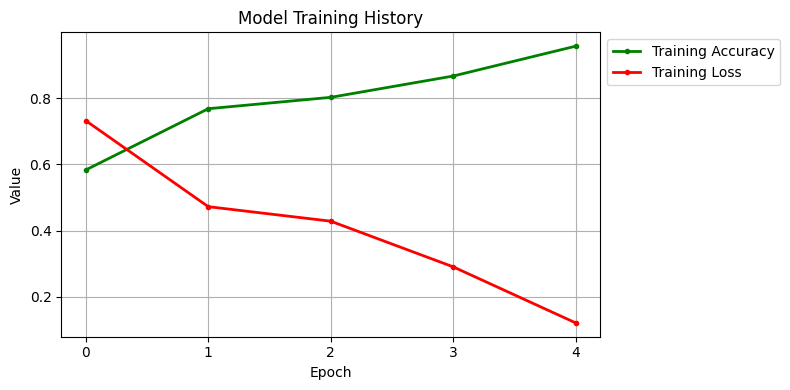

In [41]:
#Train and Val Plots
plt.figure(figsize=(8, 4))
plt.grid(True)

# Plot accuracy
plt.plot(history.history.get('sparse_categorical_accuracy'), 'g.-', linewidth=2, label='Training Accuracy')

# Plot loss
plt.plot(history.history.get('loss'), 'r.-', linewidth=2, label='Training Loss')

plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(epochs))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 158s 20s/step
Classification Report:
              precision    recall  f1-score   support

    no-tumor       0.97      0.97      0.97        98
       tumor       0.98      0.98      0.98       155

    accuracy                           0.98       253
   macro avg       0.98      0.98      0.98       253
weighted avg       0.98      0.98      0.98       253



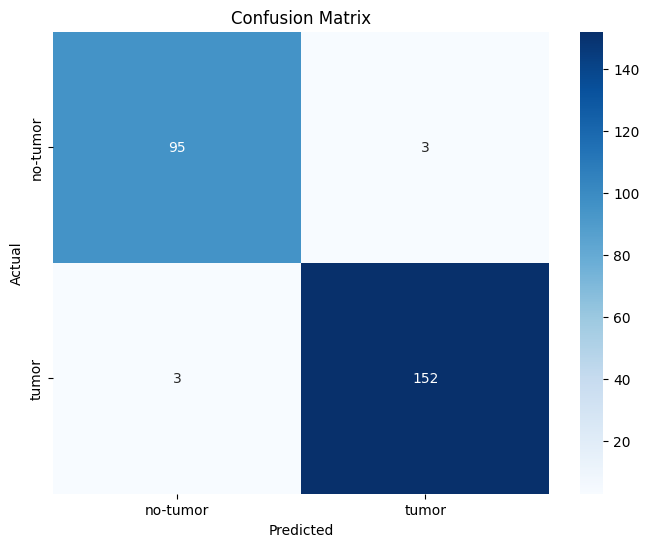

In [42]:
#Model Classification Report & Model Confusion Plot
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Load test images without augmentation
test_images = open_images(test_paths, augment=False)

# Encode test labels using the same mapping as during training
test_labels_encoded = encode_labels(test_labels, label_to_index)

# Predict
test_predictions = model.predict(test_images)
predicted_labels = np.argmax(test_predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, predicted_labels, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(test_labels_encoded, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


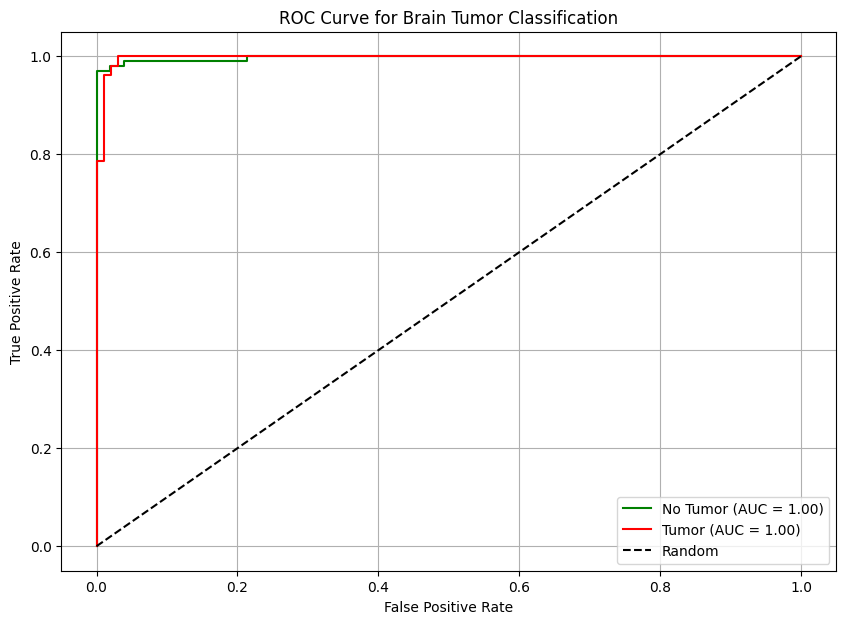

In [44]:
#Roc Curve Plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Class labels
class_labels = ['notumor', 'tumor']  # 0 = notumor, 1 = tumor

# Get predicted probabilities for both classes
notumor_probs = test_predictions[:, 0]
tumor_probs = test_predictions[:, 1]

# Compute ROC for 'notumor' class
fpr_notumor, tpr_notumor, _ = roc_curve(test_labels_encoded, notumor_probs, pos_label=0)
roc_auc_notumor = auc(fpr_notumor, tpr_notumor)

# Compute ROC for 'tumor' class
fpr_tumor, tpr_tumor, _ = roc_curve(test_labels_encoded, tumor_probs, pos_label=1)
roc_auc_tumor = auc(fpr_tumor, tpr_tumor)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_notumor, tpr_notumor, label=f'No Tumor (AUC = {roc_auc_notumor:.2f})', color='green')
plt.plot(fpr_tumor, tpr_tumor, label=f'Tumor (AUC = {roc_auc_tumor:.2f})', color='red')

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Plot settings
plt.title('ROC Curve for Brain Tumor Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [45]:
#Save & Load Model
model.save('my_model.keras')

In [46]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('my_model.keras')


In [47]:
# MRI Tumor Detection System
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['notumor', 'tumor']

def detect_and_display(img_path, model, image_size=224):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


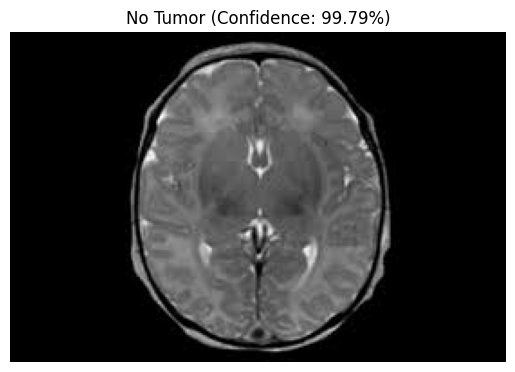

In [48]:
# Example usage
image_path = '/content/drive/MyDrive/DataSet_MRI_scans/brain_tumor_dataset/No-Tumor/12 no.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


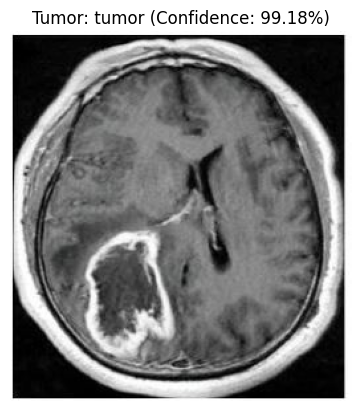

In [49]:
# Example usage
image_path = '/content/drive/MyDrive/DataSet_MRI_scans/brain_tumor_dataset/Tumor/Y109.JPG'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


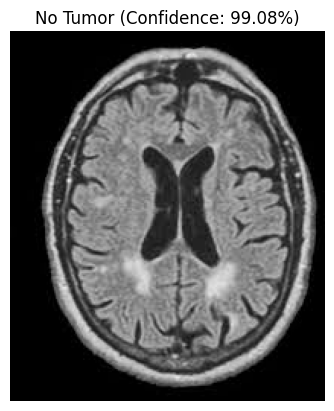

In [50]:
 # Example usage
image_path = '/content/drive/MyDrive/DataSet_MRI_scans/brain_tumor_dataset/No-Tumor/22 no.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


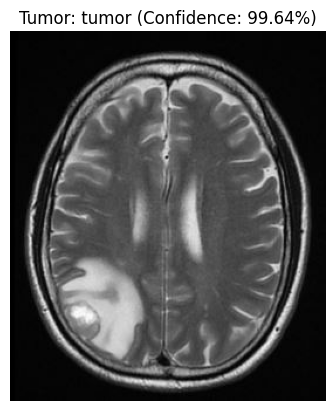

In [51]:
 # Example usage
image_path = '/content/drive/MyDrive/DataSet_MRI_scans/brain_tumor_dataset/Tumor/Y163.JPG'  # Provide the path to your new image
detect_and_display(image_path, model)